# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

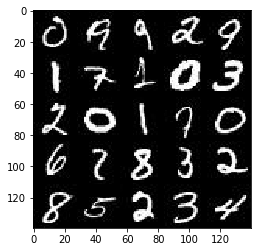

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

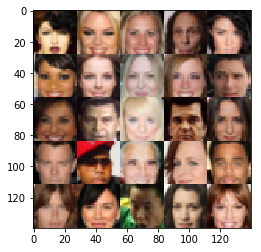

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    image_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='image_real')
    Z_input = tf.placeholder(tf.float32, [None, z_dim], name='Z_input')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return image_real, Z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28*28*channels
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        # Now is 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # Now is 7x7x128
        
    
        # Flatten
        #flatten = tf.contrib.layers.flatten(relu2)
        flatten = tf.reshape(relu2, (-1, 7*7*128))
        
        # Fully connected layer
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
        
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*128)
        
        # Reshape
        x2 = tf.reshape(x1, [-1, 7, 7, 128])
        #x2 = tf.contrib.layers.flatten(x2)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # Now is 7x7x128
        
        x3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # Now is 14*14*64
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        # Now is 28*28*3
        
        output = tf.tanh(logits)
        
        
    return output
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
  
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,\
                                                                        labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,\
                                                                        labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,\
                                                                   labels=tf.ones_like(d_logits_fake)))
    
                                 
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    losses, samples = [], []
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Train Model
                steps += 1
                
                # Multiply 2 change from (-0.5, 0.5) to (-1, 1)
                batch_images = batch_images*2
                
                #Sample radom noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizer, The generator doesn't actually use input_real in g_train_opt
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                
                # Print loss every 10 batches
                if steps % 10==0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append([train_loss_d, train_loss_g])
                 
                # Print samples every 100 batches
                if steps % 100==0:
                    gen_samples = show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
                    samples.append(gen_samples)
        #saver.save(sess, './checkpoints/generator.ckpt')
     
    #     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)
    
    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0209... Generator Loss: 0.7930
Epoch 1/2... Discriminator Loss: 0.6839... Generator Loss: 1.4166
Epoch 1/2... Discriminator Loss: 0.8194... Generator Loss: 1.2525
Epoch 1/2... Discriminator Loss: 0.7854... Generator Loss: 1.8471
Epoch 1/2... Discriminator Loss: 0.9172... Generator Loss: 1.7696
Epoch 1/2... Discriminator Loss: 0.7592... Generator Loss: 1.2001
Epoch 1/2... Discriminator Loss: 0.6413... Generator Loss: 1.5596
Epoch 1/2... Discriminator Loss: 1.0412... Generator Loss: 3.0773
Epoch 1/2... Discriminator Loss: 0.6592... Generator Loss: 1.7802
Epoch 1/2... Discriminator Loss: 0.7802... Generator Loss: 1.3072


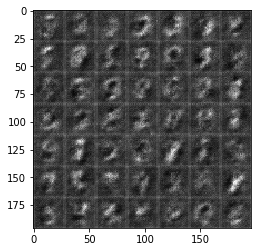

Epoch 1/2... Discriminator Loss: 0.8138... Generator Loss: 1.2851
Epoch 1/2... Discriminator Loss: 0.7842... Generator Loss: 1.4805
Epoch 1/2... Discriminator Loss: 0.9383... Generator Loss: 0.9543
Epoch 1/2... Discriminator Loss: 0.8801... Generator Loss: 1.2677
Epoch 1/2... Discriminator Loss: 0.9645... Generator Loss: 1.6297
Epoch 1/2... Discriminator Loss: 1.7172... Generator Loss: 0.3329
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 1.7173
Epoch 1/2... Discriminator Loss: 1.0960... Generator Loss: 2.1804
Epoch 1/2... Discriminator Loss: 0.9639... Generator Loss: 1.6489
Epoch 1/2... Discriminator Loss: 1.0180... Generator Loss: 0.8406


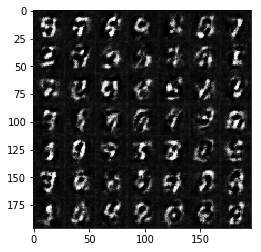

Epoch 1/2... Discriminator Loss: 1.0709... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.0656... Generator Loss: 1.7370
Epoch 1/2... Discriminator Loss: 1.1854... Generator Loss: 1.8726
Epoch 1/2... Discriminator Loss: 0.9278... Generator Loss: 1.2764
Epoch 1/2... Discriminator Loss: 0.9557... Generator Loss: 1.4165
Epoch 1/2... Discriminator Loss: 1.0968... Generator Loss: 1.8725
Epoch 1/2... Discriminator Loss: 1.0500... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 0.8921
Epoch 1/2... Discriminator Loss: 0.9789... Generator Loss: 0.9074
Epoch 1/2... Discriminator Loss: 0.9566... Generator Loss: 1.1686


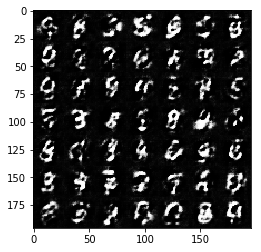

Epoch 1/2... Discriminator Loss: 1.0248... Generator Loss: 0.8438
Epoch 1/2... Discriminator Loss: 0.9425... Generator Loss: 1.4558
Epoch 1/2... Discriminator Loss: 1.0012... Generator Loss: 1.5392
Epoch 1/2... Discriminator Loss: 0.9664... Generator Loss: 1.4253
Epoch 1/2... Discriminator Loss: 0.8442... Generator Loss: 1.4235
Epoch 1/2... Discriminator Loss: 0.9250... Generator Loss: 1.2609
Epoch 1/2... Discriminator Loss: 0.9609... Generator Loss: 1.3013
Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 1.6734
Epoch 1/2... Discriminator Loss: 0.9462... Generator Loss: 1.2382
Epoch 1/2... Discriminator Loss: 0.9870... Generator Loss: 1.0102


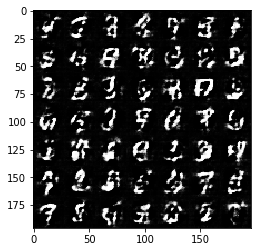

Epoch 1/2... Discriminator Loss: 0.9433... Generator Loss: 1.0212
Epoch 1/2... Discriminator Loss: 0.8885... Generator Loss: 1.3483
Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 1.2797
Epoch 1/2... Discriminator Loss: 0.9484... Generator Loss: 1.2603
Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 1.2400
Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 1.3811
Epoch 1/2... Discriminator Loss: 0.9797... Generator Loss: 1.9864
Epoch 1/2... Discriminator Loss: 0.8675... Generator Loss: 1.4631
Epoch 1/2... Discriminator Loss: 0.9174... Generator Loss: 1.4051
Epoch 1/2... Discriminator Loss: 0.9013... Generator Loss: 1.1656


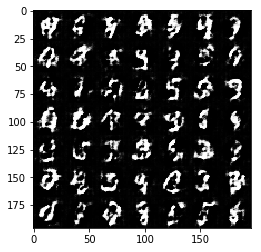

Epoch 1/2... Discriminator Loss: 0.8339... Generator Loss: 1.5314
Epoch 1/2... Discriminator Loss: 0.7575... Generator Loss: 1.3961
Epoch 1/2... Discriminator Loss: 0.9443... Generator Loss: 0.9297
Epoch 1/2... Discriminator Loss: 0.7632... Generator Loss: 1.6253
Epoch 1/2... Discriminator Loss: 0.8228... Generator Loss: 1.5831
Epoch 1/2... Discriminator Loss: 0.9219... Generator Loss: 1.1968
Epoch 1/2... Discriminator Loss: 0.9590... Generator Loss: 2.1168
Epoch 1/2... Discriminator Loss: 0.8308... Generator Loss: 1.4791
Epoch 1/2... Discriminator Loss: 0.7992... Generator Loss: 1.3959
Epoch 1/2... Discriminator Loss: 0.8475... Generator Loss: 1.1831


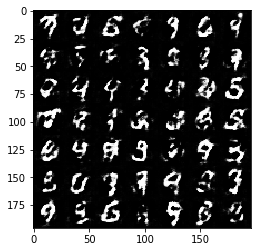

Epoch 1/2... Discriminator Loss: 0.8361... Generator Loss: 1.7548
Epoch 1/2... Discriminator Loss: 0.7568... Generator Loss: 1.3268
Epoch 1/2... Discriminator Loss: 0.8033... Generator Loss: 1.8176
Epoch 1/2... Discriminator Loss: 0.8712... Generator Loss: 1.1251
Epoch 1/2... Discriminator Loss: 0.8844... Generator Loss: 0.9968
Epoch 1/2... Discriminator Loss: 0.7845... Generator Loss: 2.1502
Epoch 1/2... Discriminator Loss: 0.7498... Generator Loss: 1.6527
Epoch 1/2... Discriminator Loss: 0.9628... Generator Loss: 0.9242
Epoch 1/2... Discriminator Loss: 0.8321... Generator Loss: 1.1436
Epoch 1/2... Discriminator Loss: 0.7041... Generator Loss: 1.7871


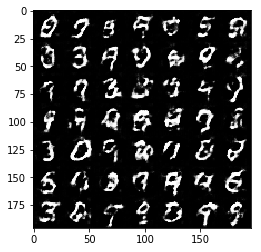

Epoch 1/2... Discriminator Loss: 0.7640... Generator Loss: 1.6155
Epoch 1/2... Discriminator Loss: 0.7311... Generator Loss: 1.4552
Epoch 1/2... Discriminator Loss: 0.7717... Generator Loss: 1.5884
Epoch 1/2... Discriminator Loss: 0.7814... Generator Loss: 1.4534
Epoch 1/2... Discriminator Loss: 0.7712... Generator Loss: 1.5667
Epoch 1/2... Discriminator Loss: 0.8964... Generator Loss: 1.0866
Epoch 1/2... Discriminator Loss: 0.7531... Generator Loss: 1.8451
Epoch 1/2... Discriminator Loss: 0.8567... Generator Loss: 1.1547
Epoch 1/2... Discriminator Loss: 0.7663... Generator Loss: 1.7652
Epoch 1/2... Discriminator Loss: 0.7900... Generator Loss: 1.7461


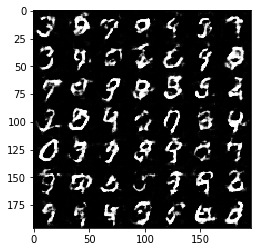

Epoch 1/2... Discriminator Loss: 0.7339... Generator Loss: 1.5333
Epoch 1/2... Discriminator Loss: 0.8617... Generator Loss: 1.9310
Epoch 1/2... Discriminator Loss: 0.9377... Generator Loss: 2.2857
Epoch 1/2... Discriminator Loss: 0.8174... Generator Loss: 1.6077
Epoch 1/2... Discriminator Loss: 0.7863... Generator Loss: 1.4316
Epoch 1/2... Discriminator Loss: 0.8099... Generator Loss: 1.2175
Epoch 1/2... Discriminator Loss: 0.7888... Generator Loss: 1.4987
Epoch 1/2... Discriminator Loss: 0.9038... Generator Loss: 1.0522
Epoch 1/2... Discriminator Loss: 0.8910... Generator Loss: 1.1121
Epoch 1/2... Discriminator Loss: 0.9033... Generator Loss: 1.3299


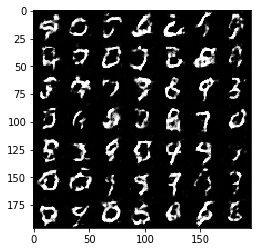

Epoch 1/2... Discriminator Loss: 0.8889... Generator Loss: 1.3135
Epoch 1/2... Discriminator Loss: 0.7612... Generator Loss: 1.5874
Epoch 1/2... Discriminator Loss: 1.1622... Generator Loss: 2.5641
Epoch 2/2... Discriminator Loss: 0.8157... Generator Loss: 1.6073
Epoch 2/2... Discriminator Loss: 0.8819... Generator Loss: 1.5419
Epoch 2/2... Discriminator Loss: 0.8552... Generator Loss: 1.7874
Epoch 2/2... Discriminator Loss: 0.8696... Generator Loss: 1.4711
Epoch 2/2... Discriminator Loss: 0.8634... Generator Loss: 1.3800
Epoch 2/2... Discriminator Loss: 0.8289... Generator Loss: 1.4108
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 1.2676


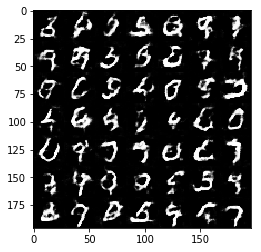

Epoch 2/2... Discriminator Loss: 0.8137... Generator Loss: 1.2388
Epoch 2/2... Discriminator Loss: 0.8158... Generator Loss: 1.4819
Epoch 2/2... Discriminator Loss: 0.9250... Generator Loss: 1.2663
Epoch 2/2... Discriminator Loss: 0.8196... Generator Loss: 1.7866
Epoch 2/2... Discriminator Loss: 0.9172... Generator Loss: 1.0926
Epoch 2/2... Discriminator Loss: 1.1035... Generator Loss: 2.1157
Epoch 2/2... Discriminator Loss: 0.8469... Generator Loss: 1.2396
Epoch 2/2... Discriminator Loss: 0.8276... Generator Loss: 1.3785
Epoch 2/2... Discriminator Loss: 0.8939... Generator Loss: 2.1236
Epoch 2/2... Discriminator Loss: 0.8614... Generator Loss: 1.4294


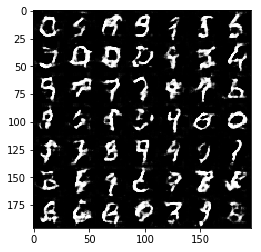

Epoch 2/2... Discriminator Loss: 0.9215... Generator Loss: 1.9664
Epoch 2/2... Discriminator Loss: 0.9306... Generator Loss: 1.0133
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.4224
Epoch 2/2... Discriminator Loss: 0.9202... Generator Loss: 1.0505
Epoch 2/2... Discriminator Loss: 0.8904... Generator Loss: 1.0568
Epoch 2/2... Discriminator Loss: 0.8861... Generator Loss: 1.1489
Epoch 2/2... Discriminator Loss: 1.1057... Generator Loss: 2.4383
Epoch 2/2... Discriminator Loss: 0.8438... Generator Loss: 1.2671
Epoch 2/2... Discriminator Loss: 0.8850... Generator Loss: 1.2461
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 1.1971


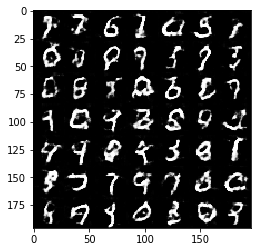

Epoch 2/2... Discriminator Loss: 0.8706... Generator Loss: 1.3061
Epoch 2/2... Discriminator Loss: 0.9088... Generator Loss: 1.0967
Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 0.9854
Epoch 2/2... Discriminator Loss: 0.9273... Generator Loss: 1.3395
Epoch 2/2... Discriminator Loss: 0.9360... Generator Loss: 1.6093
Epoch 2/2... Discriminator Loss: 0.9639... Generator Loss: 1.6690
Epoch 2/2... Discriminator Loss: 0.9962... Generator Loss: 1.6922
Epoch 2/2... Discriminator Loss: 0.9655... Generator Loss: 0.9548
Epoch 2/2... Discriminator Loss: 0.8282... Generator Loss: 1.4126
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 0.7756


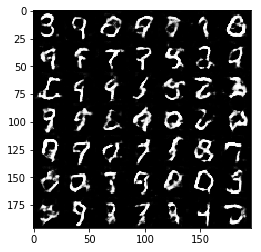

Epoch 2/2... Discriminator Loss: 0.8578... Generator Loss: 1.5673
Epoch 2/2... Discriminator Loss: 0.9040... Generator Loss: 1.3263
Epoch 2/2... Discriminator Loss: 0.9469... Generator Loss: 1.1270
Epoch 2/2... Discriminator Loss: 0.9118... Generator Loss: 1.0996
Epoch 2/2... Discriminator Loss: 0.8174... Generator Loss: 1.3048
Epoch 2/2... Discriminator Loss: 0.8111... Generator Loss: 1.6510
Epoch 2/2... Discriminator Loss: 0.9558... Generator Loss: 1.1142
Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 1.7283
Epoch 2/2... Discriminator Loss: 0.9097... Generator Loss: 1.5929
Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 2.2236


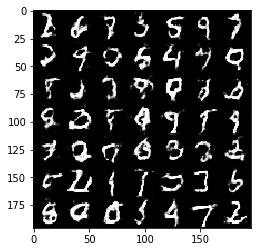

Epoch 2/2... Discriminator Loss: 0.9011... Generator Loss: 1.5821
Epoch 2/2... Discriminator Loss: 0.9482... Generator Loss: 1.0650
Epoch 2/2... Discriminator Loss: 1.0641... Generator Loss: 0.7673
Epoch 2/2... Discriminator Loss: 0.9340... Generator Loss: 1.8742
Epoch 2/2... Discriminator Loss: 0.9200... Generator Loss: 1.0758
Epoch 2/2... Discriminator Loss: 0.7975... Generator Loss: 1.5055
Epoch 2/2... Discriminator Loss: 0.9359... Generator Loss: 0.9765
Epoch 2/2... Discriminator Loss: 0.9013... Generator Loss: 1.1868
Epoch 2/2... Discriminator Loss: 0.8419... Generator Loss: 1.4698
Epoch 2/2... Discriminator Loss: 1.0257... Generator Loss: 0.7957


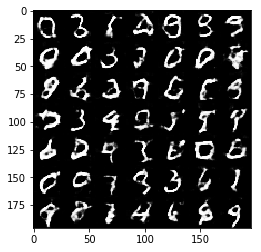

Epoch 2/2... Discriminator Loss: 1.0903... Generator Loss: 0.7878
Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 0.9226
Epoch 2/2... Discriminator Loss: 0.8402... Generator Loss: 1.2412
Epoch 2/2... Discriminator Loss: 1.0223... Generator Loss: 2.0366
Epoch 2/2... Discriminator Loss: 0.8957... Generator Loss: 1.0787
Epoch 2/2... Discriminator Loss: 0.9253... Generator Loss: 0.9646
Epoch 2/2... Discriminator Loss: 0.8441... Generator Loss: 1.6348
Epoch 2/2... Discriminator Loss: 0.8822... Generator Loss: 1.4284
Epoch 2/2... Discriminator Loss: 0.8499... Generator Loss: 1.4581
Epoch 2/2... Discriminator Loss: 1.0541... Generator Loss: 0.7884


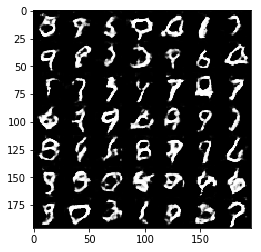

Epoch 2/2... Discriminator Loss: 0.8335... Generator Loss: 1.1776
Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 2.0951
Epoch 2/2... Discriminator Loss: 0.7930... Generator Loss: 1.3551
Epoch 2/2... Discriminator Loss: 0.7661... Generator Loss: 1.4647
Epoch 2/2... Discriminator Loss: 0.8322... Generator Loss: 1.5329
Epoch 2/2... Discriminator Loss: 1.0174... Generator Loss: 2.1434
Epoch 2/2... Discriminator Loss: 0.7990... Generator Loss: 1.6956
Epoch 2/2... Discriminator Loss: 0.8641... Generator Loss: 1.9624
Epoch 2/2... Discriminator Loss: 0.8715... Generator Loss: 1.1940
Epoch 2/2... Discriminator Loss: 0.8084... Generator Loss: 1.4265


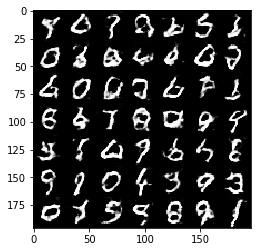

Epoch 2/2... Discriminator Loss: 0.8345... Generator Loss: 1.5269
Epoch 2/2... Discriminator Loss: 1.0145... Generator Loss: 1.5728
Epoch 2/2... Discriminator Loss: 0.9675... Generator Loss: 0.9724
Epoch 2/2... Discriminator Loss: 0.9515... Generator Loss: 1.7592
Epoch 2/2... Discriminator Loss: 0.9245... Generator Loss: 0.9946
Epoch 2/2... Discriminator Loss: 0.9249... Generator Loss: 1.8054
Epoch 2/2... Discriminator Loss: 1.0720... Generator Loss: 0.7820
Epoch 2/2... Discriminator Loss: 0.8205... Generator Loss: 1.2356
Epoch 2/2... Discriminator Loss: 0.8663... Generator Loss: 1.1381
Epoch 2/2... Discriminator Loss: 0.9085... Generator Loss: 1.0996


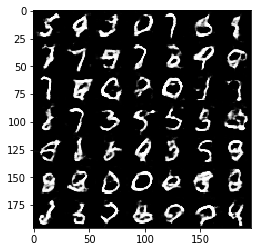

Epoch 2/2... Discriminator Loss: 0.8641... Generator Loss: 1.5338
Epoch 2/2... Discriminator Loss: 0.8959... Generator Loss: 1.0406
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 1.7359
Epoch 2/2... Discriminator Loss: 0.8516... Generator Loss: 1.3203
Epoch 2/2... Discriminator Loss: 0.8448... Generator Loss: 1.2169
Epoch 2/2... Discriminator Loss: 0.8252... Generator Loss: 1.5191
Epoch 2/2... Discriminator Loss: 0.7961... Generator Loss: 1.4124


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 0.7025... Generator Loss: 1.5939
Epoch 1/1... Discriminator Loss: 0.6026... Generator Loss: 1.9540
Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 2.1888
Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 2.6607
Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 2.5588
Epoch 1/1... Discriminator Loss: 0.4500... Generator Loss: 2.7086
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 2.8097
Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 2.0129
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 2.1116


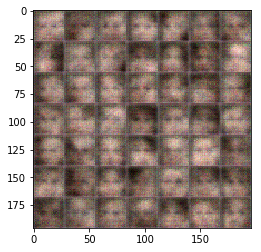

Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 1.6998
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.0497
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 2.1448
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.6260
Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 1.8475
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 1.0630
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 2.1953
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.3183
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 0.8718


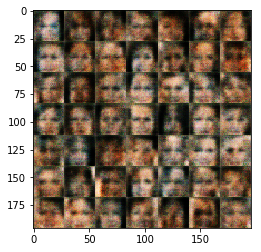

Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 1.4217
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.7093
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.9195
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 1.6420
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.4995


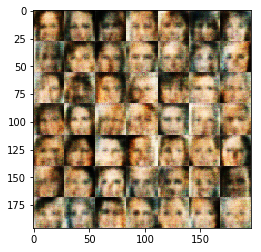

Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.1100
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 1.4402
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.4465
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 2.1859
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 1.0061


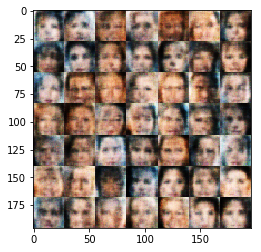

Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.6895
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.3678
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 1.1628
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 1.6700
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 1.7891
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 1.1981
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 2.0821
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 1.0664


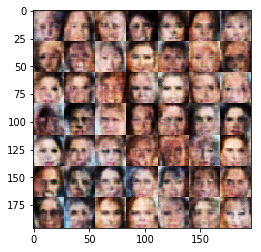

Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.2513
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.4972
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.3338
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 0.8880... Generator Loss: 1.4004
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 1.4154
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 1.2382
Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 1.8167


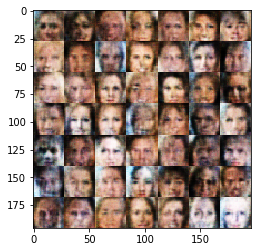

Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 1.3666
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 1.3910
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.2333
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 1.7384
Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 1.1246
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 1.2631
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 1.4269
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 1.4985


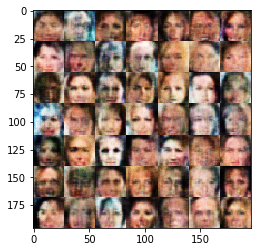

Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 1.7678
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 1.3963
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 1.0847
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 1.1947
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 1.4991
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 1.1338


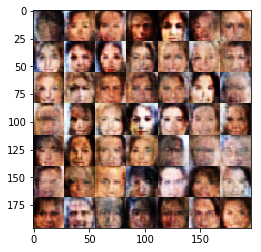

Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 1.0127


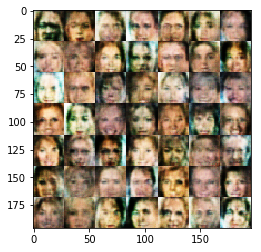

Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 1.0868


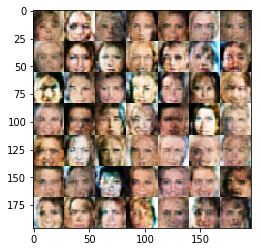

Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.9470


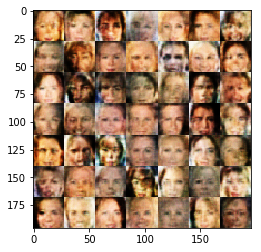

Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.7419


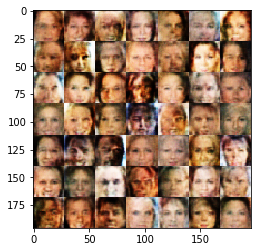

Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 1.1586
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 1.0064
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.9721


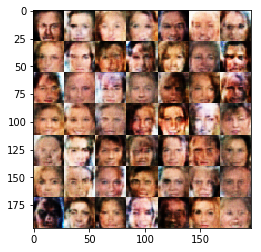

Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 1.0107
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 1.3893
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 1.2494
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 1.1157


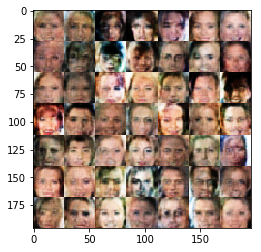

Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 1.2654
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 1.2329
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 1.1380
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 1.2505
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.8794


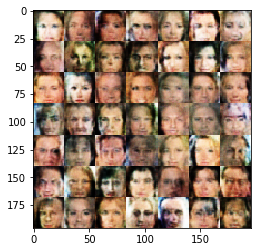

Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 1.3187
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.9823


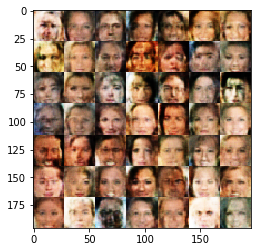

Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 1.1748
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 1.0892
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 1.1886
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.2519
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 1.0566
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 0.8173


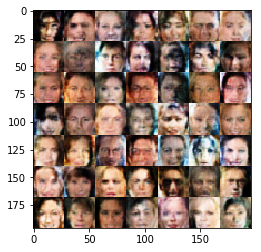

Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 1.0611
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 1.1973
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 1.0949
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 1.0578
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.6688


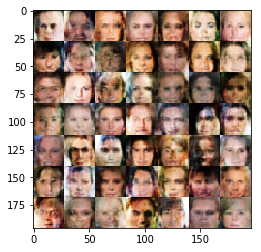

Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 1.2654
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 1.8309
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 1.1804
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 1.2992


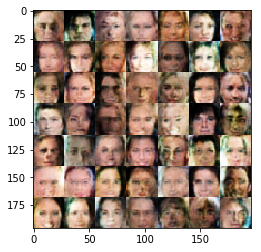

Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.4734
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.2451
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.9003


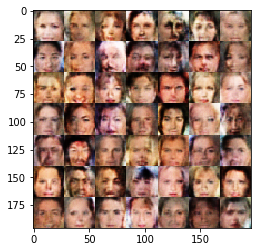

Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 1.1578
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 1.1163
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.8124


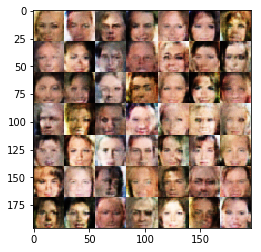

Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 1.2316
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.9967
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 1.3416
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 1.0436


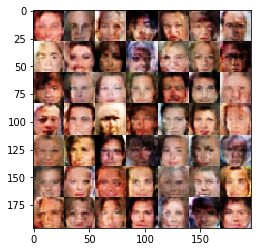

Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.3194
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 1.1860


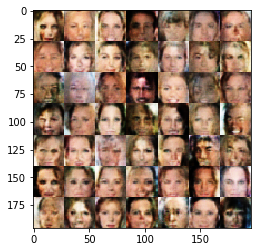

Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 1.0628
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 1.2027
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7261


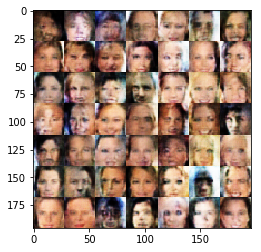

Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 1.1852
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.5053
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.5329... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 1.1462


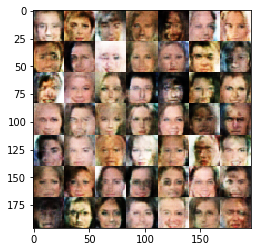

Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 1.2069
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.2875
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.9939


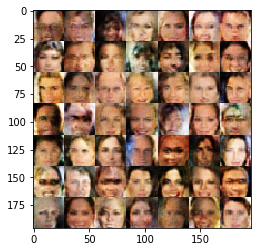

Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 1.3242
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 1.1451
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6002


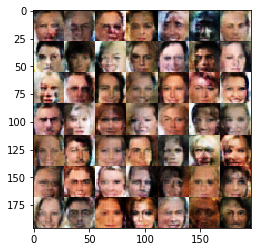

Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 1.2699
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 1.3261
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 1.1101


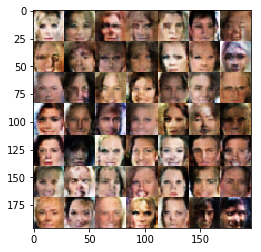

Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 1.4374
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.0601
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 1.5933
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 1.4329
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.8199


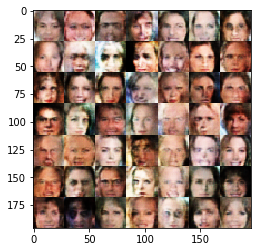

Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.5933
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 1.2142
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 1.0763
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 1.1365
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 1.2201


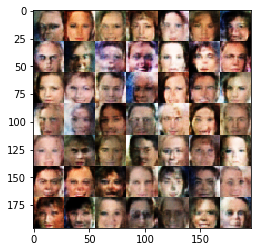

Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.3346
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.7170


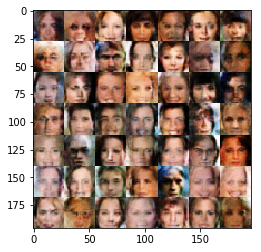

Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 1.2523
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 1.5214
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.8172


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

# Avoid stacking memory
tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.